# CSC3831 Coursework Part 1: Data Engineering



In [2]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

# Loading in the corrupted dataset to be used in analysis and imputation
hc_path = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv'
houses_corrupted = pd.read_csv(hc_path, header=0)

# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


In [3]:
houses_corrupted.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,NaN,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,NaN,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


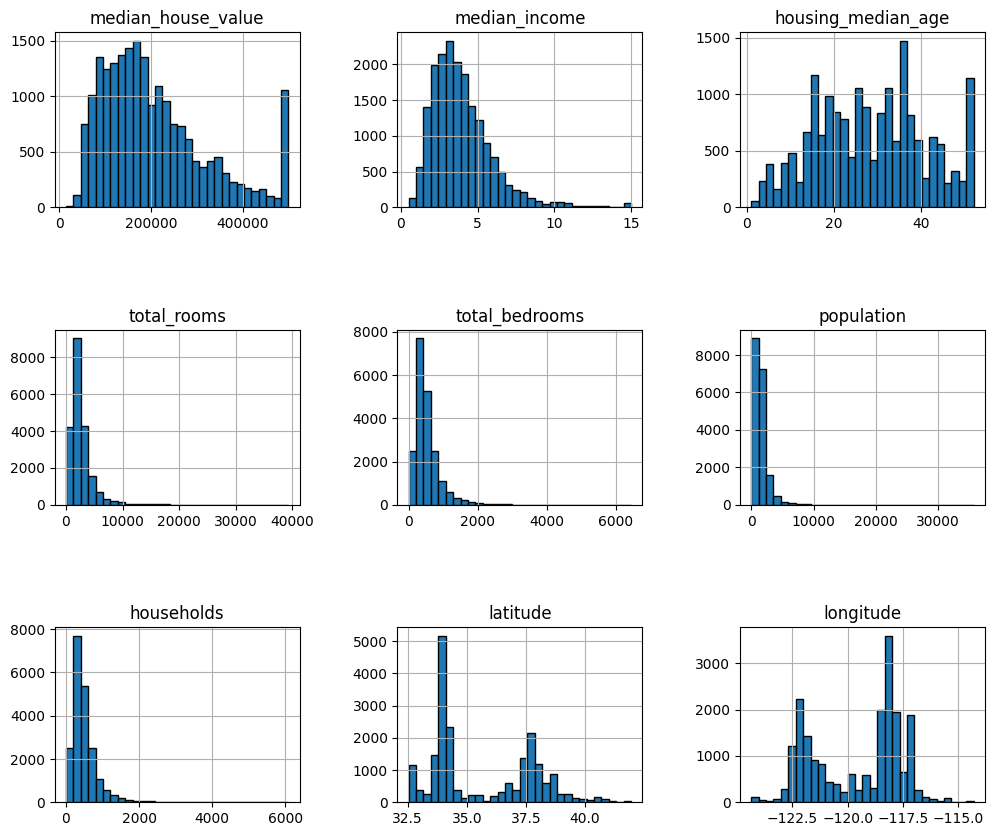

In [4]:
import matplotlib.pyplot as plt

houses_corrupted.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [5]:
houses_corrupted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
missing_count=houses_corrupted.isnull().sum()
missing_count = missing_count[missing_count>0]

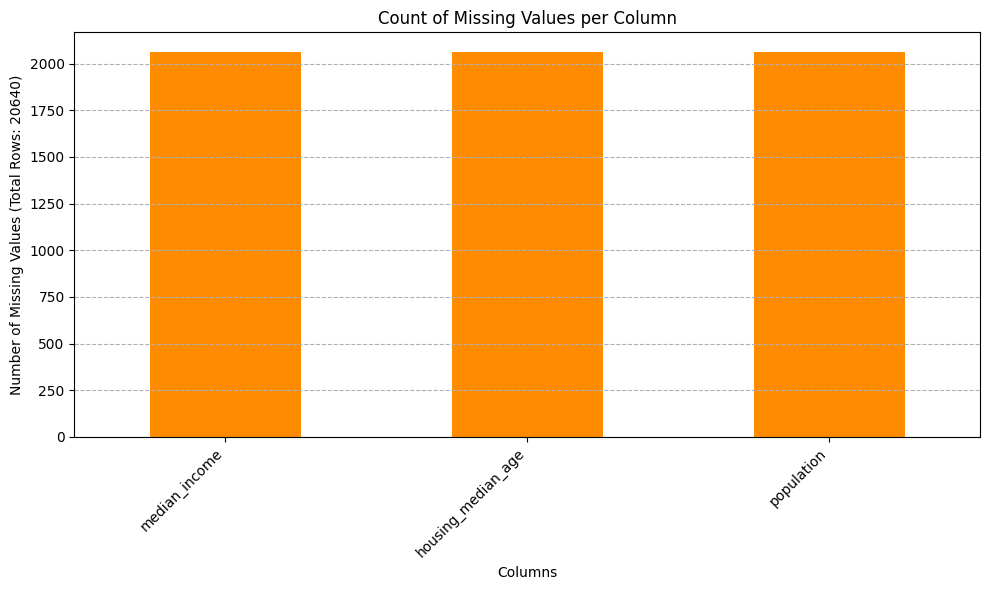

In [7]:
plt.figure(figsize=(10, 6))
missing_count.plot(kind='bar', color='darkorange')
plt.title('Count of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values (Total Rows: 20640)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

Since the number of missing values in the of all the columns is the same, it is worth checking if the same rows have 3 of these values missing all the time as it might suggest some direct patterns that can be handled in one step, based on the result below, the data seems to be missing randomly or without any direct correlation 

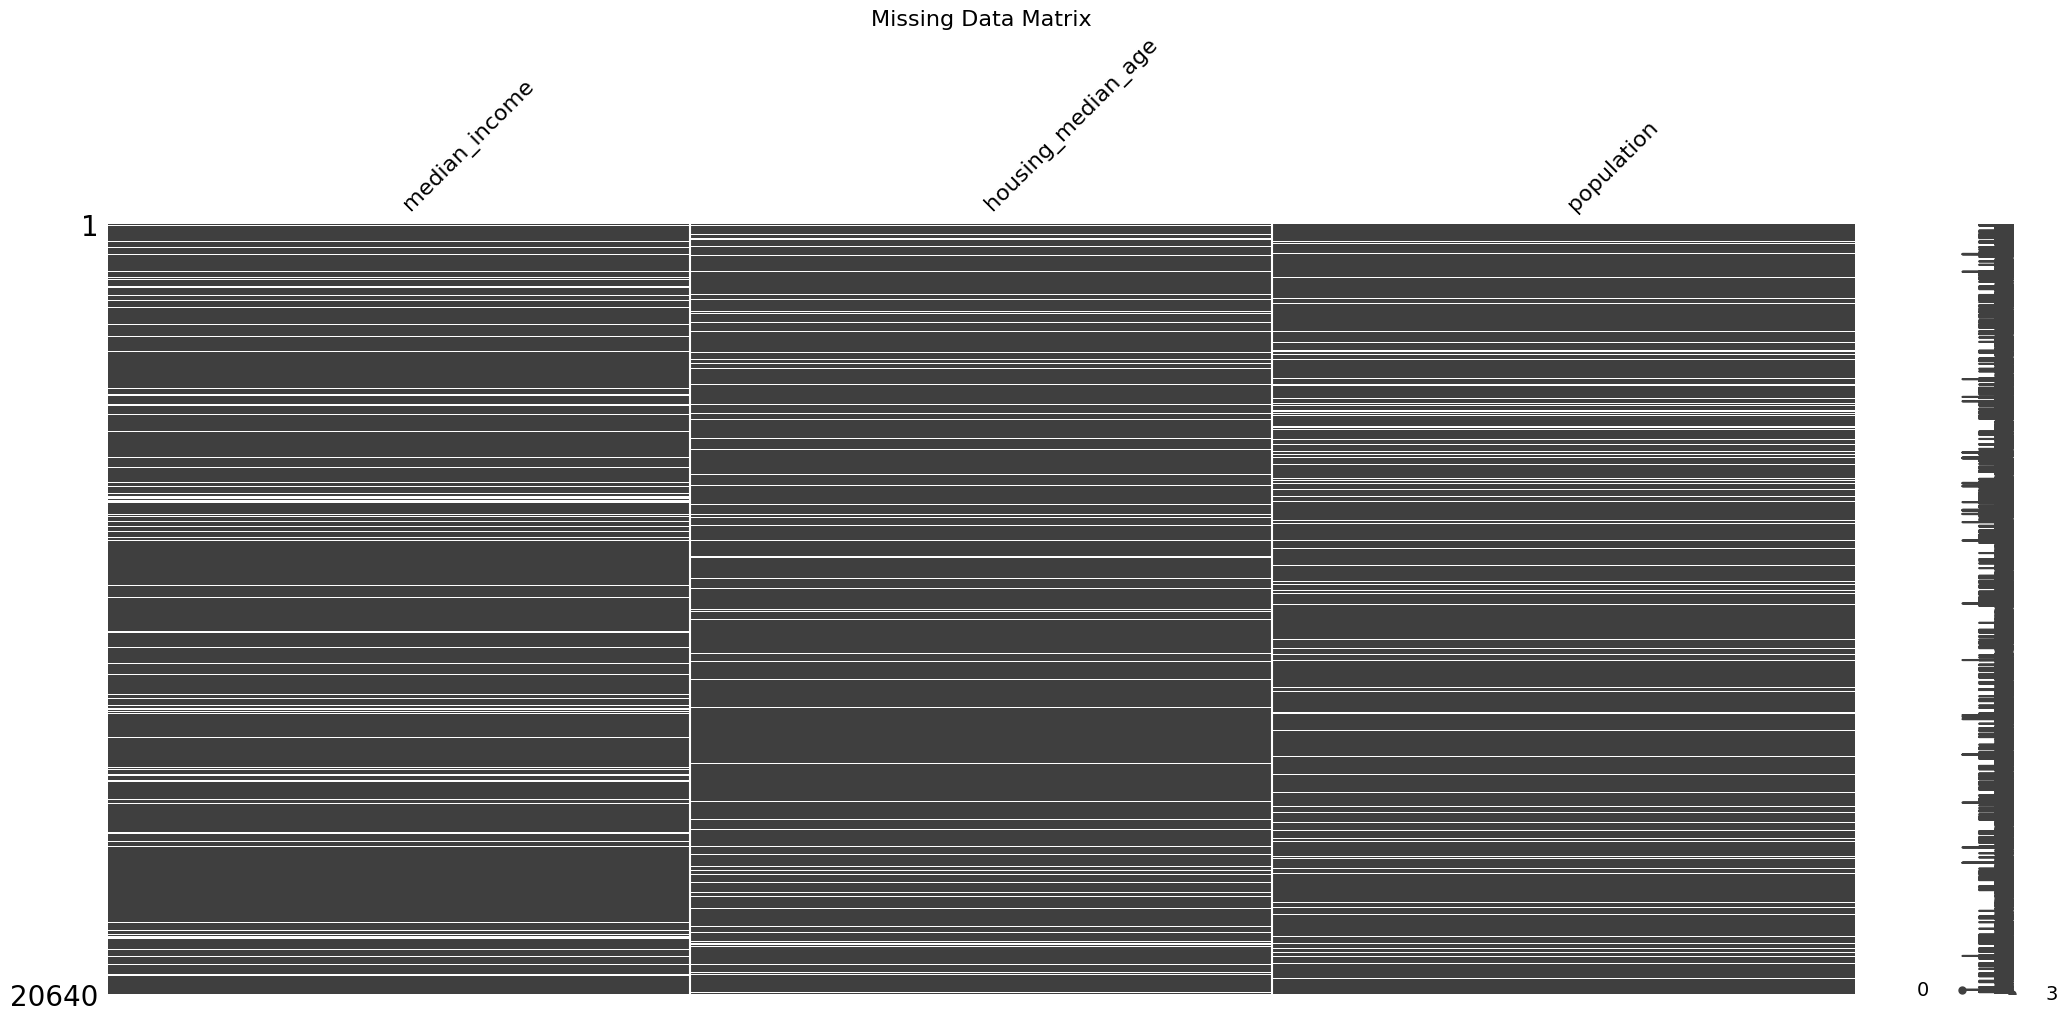

In [8]:
# mapping the missing columns to check if there are any direct correlations in the data that is missing or any direct relationships 
msno.matrix(houses_corrupted[["median_income", "housing_median_age", "population"]])
plt.title('Missing Data Matrix', fontsize=16)
plt.show()


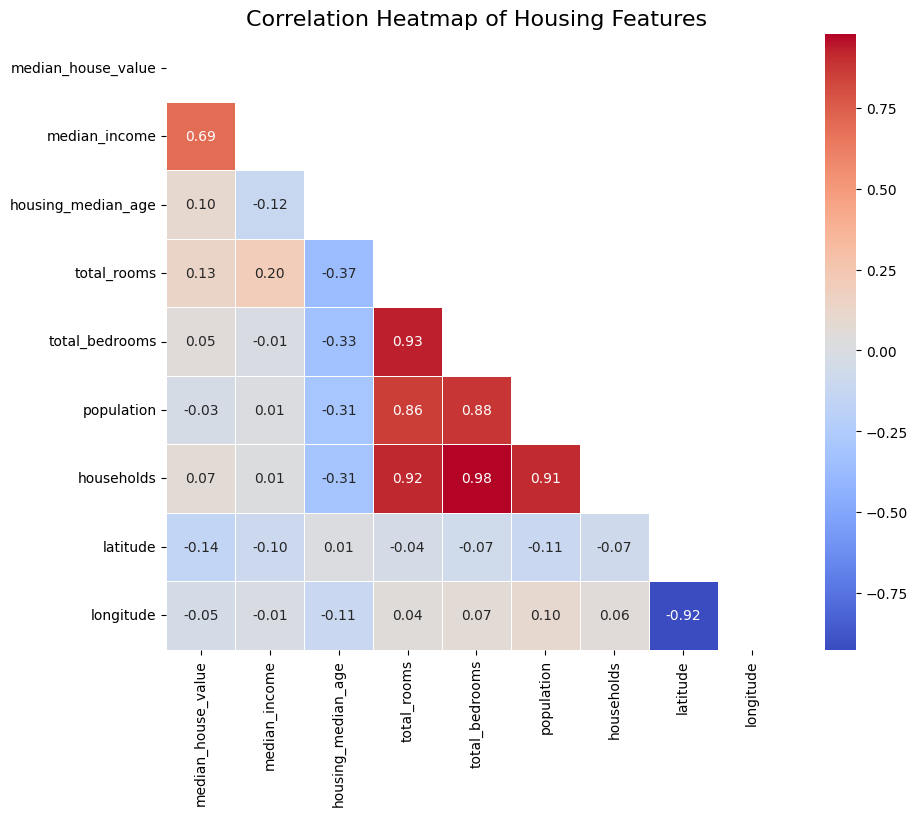

In [9]:
# Calculate the correlation matrix
correlation_matrix = houses_corrupted.corr()

plt.figure(figsize=(10, 8))
#for masking the upper half o the triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',  
    mask=mask,
    fmt=".2f",
    linewidths=0.5,
    cbar=True
)

plt.title('Correlation Heatmap of Housing Features', fontsize=16)
plt.show()

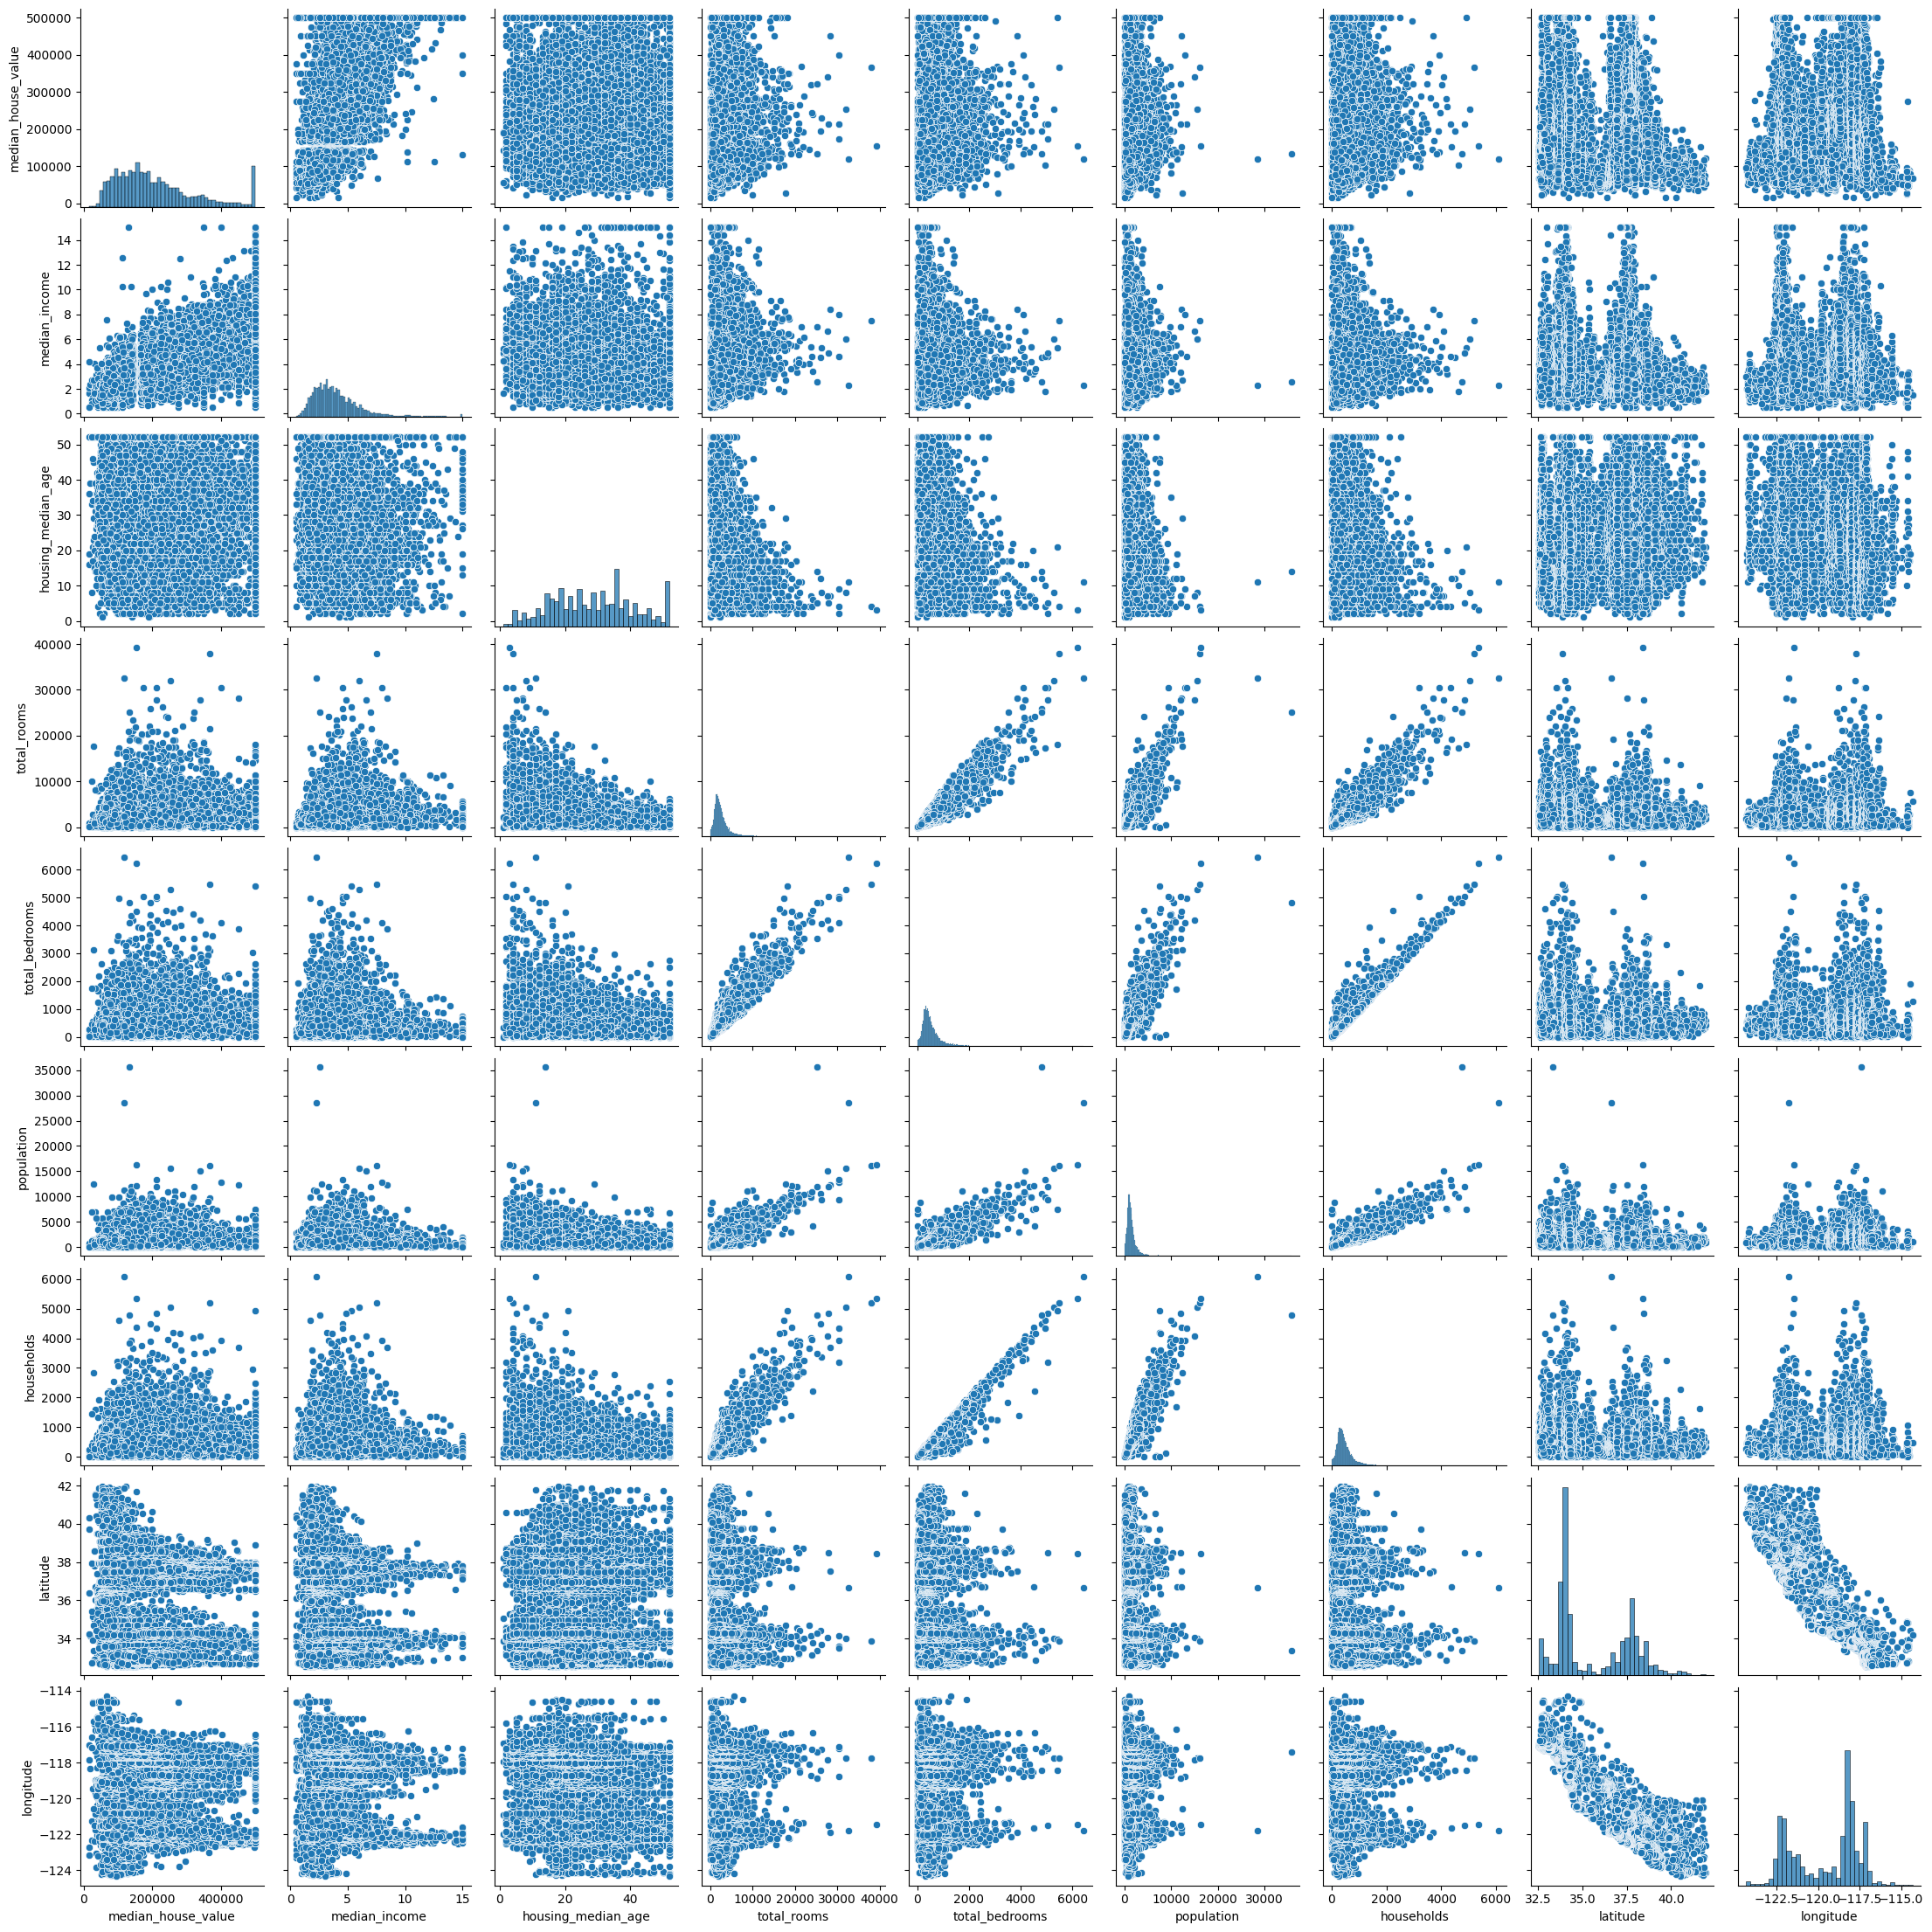

In [17]:
sns.pairplot(houses_corrupted)

Very obvious strong positive coorelations can be observed with some of the the above pair plots:  
1. total_bedrooms vs total rooms: as the number of bedrooms increase the total number of rooms increase and the vice versa is very likely  
2. population vs households: as the number of people increase, the number of households increase and vice versa 


Do a pairwise plot
What type of data missingness is this?


### Most Correlated Features:  
1. Households and total rooms  
2. Households and total_bedrooms  
3. Households and total_population  
4. Total Bedrooms and total rooms  
5. Population and total rooms  
6. Median income and Median house value (people who earn more tend to have more expensive houses)

Text(0, 0.5, 'Median income (x10k USD)')

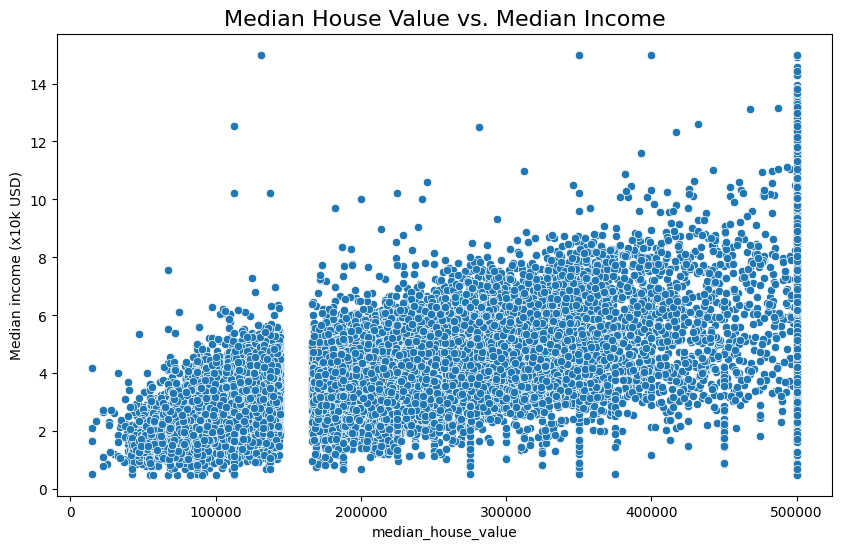

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=houses_corrupted, x='median_house_value', y='median_income')
plt.title('Median House Value vs. Median Income', fontsize=16)
plt.ylabel('Median income (x10k USD)')

### Trends or patterns identified  
1. The max median house value is capped at 500000 USD  
2. There is a "gap" on the x-axis around the 150,000 USD mark where the median income was rounded off to a lower value.  
_Hypothesis_: The council has done this to create a logical cut of point a create a classifcation for low and high value houses for each of these locations  
3. There is a positie linear correlation identified with these variables and when generalized can be said that as the median income increases, the price of the houses increase as well

###TO DO: Show a correlation between income and median house value: scale the data 

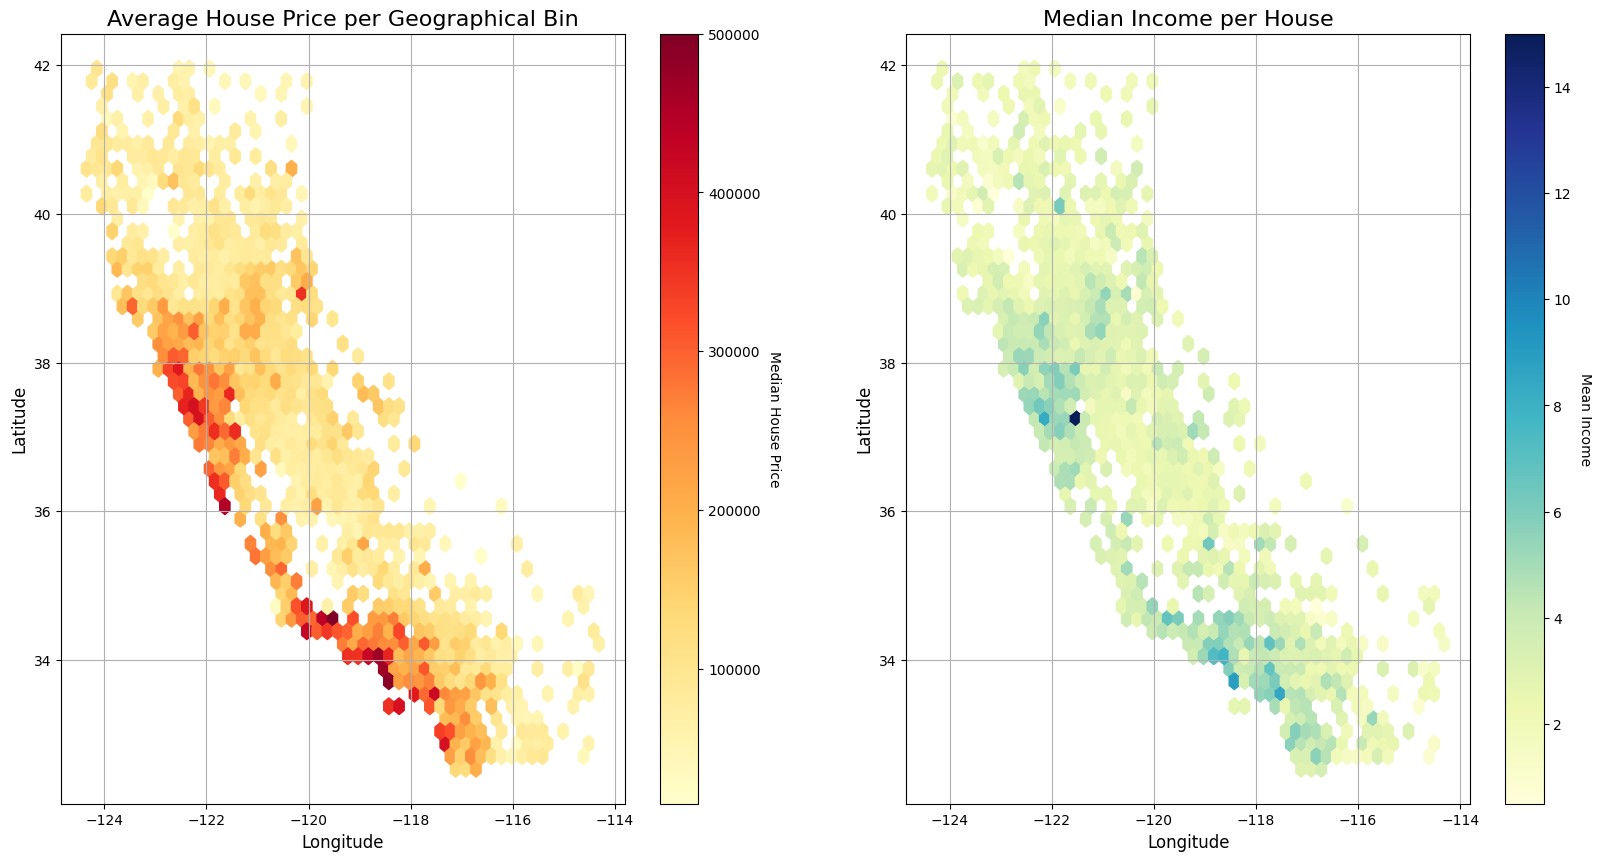

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # 1 row, 2 columns

# --- First Plot: Average House Price (Hexbin) ---
ax1 = axes[0]
hb1 = ax1.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['median_house_value'],
    gridsize=50,
    cmap=plt.get_cmap("YlOrRd"), # Yellow-Orange-Red
    reduce_C_function=np.mean
)

# Set title and labels for the first plot
ax1.set_title("Average House Price per Geographical Bin", fontsize=16)
ax1.set_xlabel("Longitude", fontsize=12)
ax1.set_ylabel("Latitude", fontsize=12)
ax1.grid(True)

# Add color bar for the first plot
cbar1 = fig.colorbar(hb1, ax=ax1)
cbar1.set_label('Median House Price', rotation=270, labelpad=15)

# --- Second Plot: Mean Income (Hexbin) ---
ax2 = axes[1]
hb2 = ax2.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['median_income'],
    gridsize=50,
    cmap=plt.get_cmap("YlGnBu"), # Yellow-Green-Blue for distinction
    reduce_C_function=np.mean
)

# Set title and labels for the second plot
ax2.set_title("Median Income per House", fontsize=16)
ax2.set_xlabel("Longitude", fontsize=12)
ax2.set_ylabel("Latitude", fontsize=12) 
ax2.grid(True)

# Add color bar for the second plot
cbar2 = fig.colorbar(hb2, ax=ax2)
cbar2.set_label('Mean Income', rotation=270, labelpad=15)



Mathematically, the above graphs show a non uniform distribution where both the house price and median income are not uniformly distributed across the state, however the trends are more geo-spacial. 

The houses along the west coast of california have a higher average price compared to the houses away from the coast (higher price might be due to proximity to water bodies that give a cooling effect and provide great views)

Upon visual examination of the California state map, the median income per house increases in the west-coast, the areas with the a higher concentration of blue spots (near (-118,34) and (-120,37)) these areas ara Los Angeles (LA) and Sacremento both of which are very prominent areas for celebrities and hosting the state capital respectively.

The above examination of the dataset shows interesting correlations in terms of location in the california state to different metrics, lets examine other metrics such as population and household density in these areas 

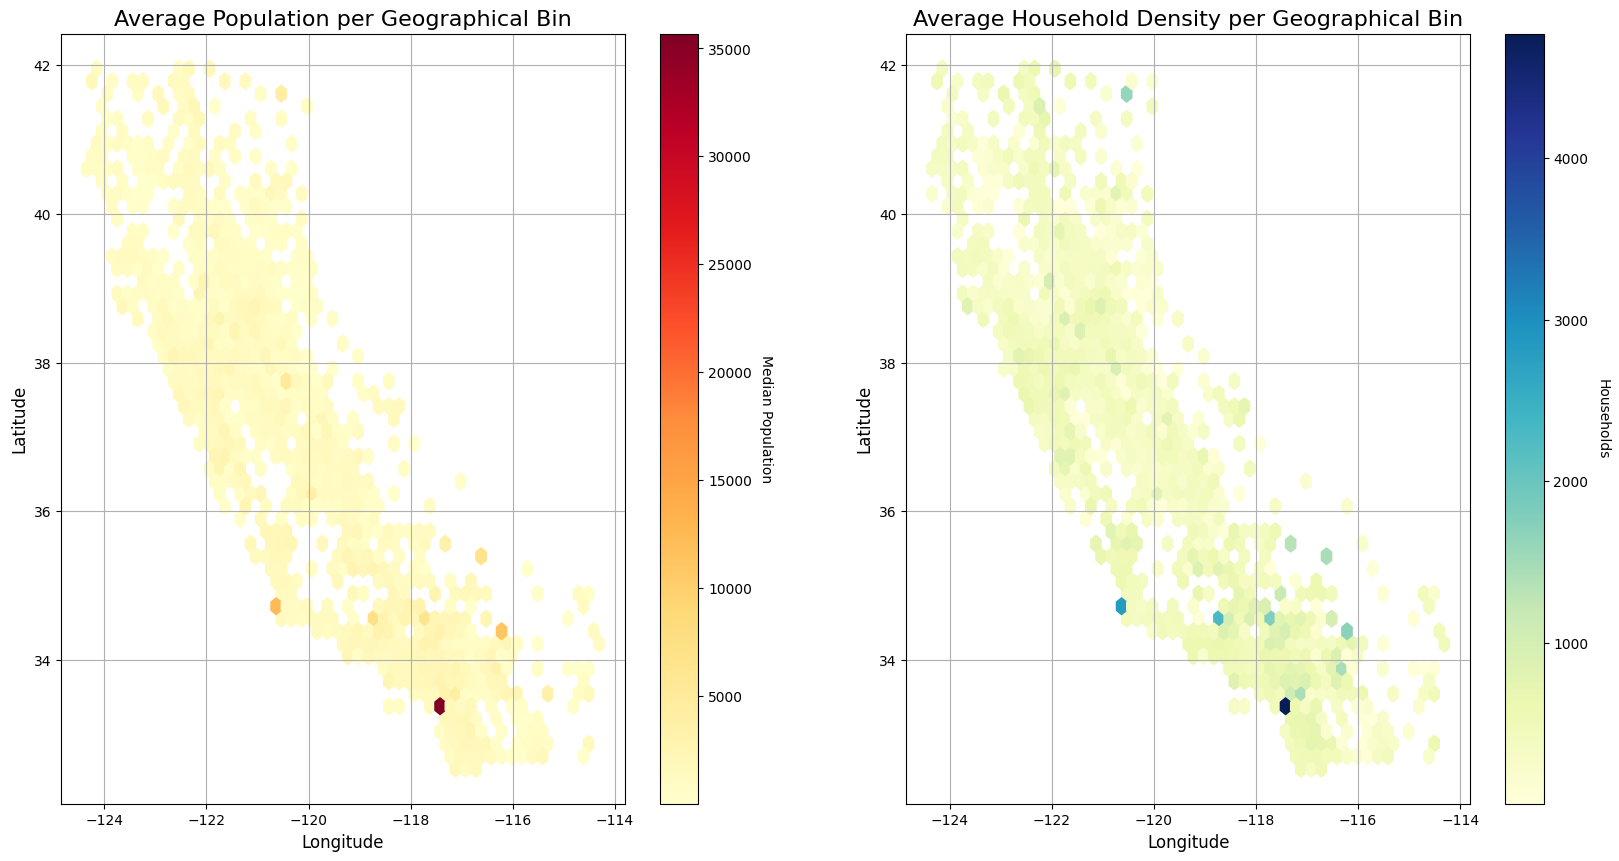

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # 1 row, 2 columns

# --- First Plot: Average House Price (Hexbin) ---
ax1 = axes[0]
hb1 = ax1.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['population'],
    gridsize=50,
    cmap=plt.get_cmap("YlOrRd"), # Yellow-Orange-Red
    reduce_C_function=np.mean
)

# Set title and labels for the first plot
ax1.set_title("Average Population per Geographical Bin", fontsize=16)
ax1.set_xlabel("Longitude", fontsize=12)
ax1.set_ylabel("Latitude", fontsize=12)
ax1.grid(True)

# Add color bar for the first plot
cbar1 = fig.colorbar(hb1, ax=ax1)
cbar1.set_label('Median Population', rotation=270, labelpad=15)

# --- Second Plot: Mean Income (Hexbin) ---
ax2 = axes[1]
hb2 = ax2.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['households'],
    gridsize=50,
    cmap=plt.get_cmap("YlGnBu"), # Yellow-Green-Blue for distinction
    reduce_C_function=np.mean
)

# Set title and labels for the second plot
ax2.set_title("Average Household Density per Geographical Bin", fontsize=16)
ax2.set_xlabel("Longitude", fontsize=12)
ax2.set_ylabel("Latitude", fontsize=12) 
ax2.grid(True)

# Add color bar for the second plot
cbar2 = fig.colorbar(hb2, ax=ax2)
cbar2.set_label('Households', rotation=270, labelpad=15)

Despite the differances in the scales for both the graphs, there is a very obvious in the population and housing desnity in Los Angeles. The population distribution and the number of households across the state is almost uniform however shows a clear anomaly near the LA region.  

Both the above sets of graphs show another interesting feature, while the density of the red dots are hihger near the LA region of the map, this is not propotionate to the income of this region (observed due to the lack of density of dark blue circles in that region) which further strengthens the argument that house price is not solely dependant on the median income however is greatly influnced by geographical regions such as (proximity to the coast, population density, housing supply demand)

### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


In [13]:
houses_corrupted.describe(include='all')

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,18576.000000,18576.000000,20640.000000,20640.000000,18576.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.929958,28.324182,2635.763081,537.898014,1488.069283,499.539680,35.631861,-119.569704
std,115395.615874,1.964296,12.584914,2181.615252,421.247906,1170.585810,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.560300,18.000000,1447.750000,295.000000,839.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.572400,28.000000,2127.000000,435.000000,1227.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.870050,37.000000,3148.000000,647.000000,1803.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


###can look at the population density per region as an anomaly, even household distribution. 
Some kind of imputation or data handling can be done with these variables to illustrate them as the target of data cleaning to ensure we recieve accurate prediction of california house pricing as they seem skew the accuracy of the results 

### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [14]:
# Use this dataset for comparison against the imputed datasets
h_path = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv'

### 4. Conclusions & Throughts [3]
- Discuss methods used for anomaly detection, pros/cons of each method
- Discuss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation